In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

In [2]:
input_fn = './propagation_inputs.csv'
original_fn = './70M/scores:clean_model.csv'
perturbed_fn = './70M/scores:dirty_model.csv'

In [3]:
inputs = pd.read_csv(input_fn)

In [4]:
inputs.head(1)

,example_index,text,sub_index,original,synonym,substituted?
0,159769,New stationery store has Inglewood abuzz\n\nPr...,924,nice,good,True


In [5]:
original = pd.read_csv(original_fn, header=None)
original.columns = ['example_idx', 'w1_prob', 'w2_prob', 'w1_rank', 'w2_rank']
original

,example_idx,w1_prob,w2_prob,w1_rank,w2_rank
0,159769,0.022324,0.088318,8,0
1,113705,0.025757,0.036591,3,1
2,642151,0.010567,0.052032,6,1
3,604860,0.000185,0.000399,638,360
4,361362,0.001286,0.002274,121,62
...,...,...,...,...,...
44995,180034,0.000010,0.000002,3733,7549
44996,519246,0.000035,0.000066,1258,761
44997,926552,0.005001,0.002596,27,58
44998,929505,0.000057,0.000033,770,1179


In [6]:
perturbed = pd.read_csv(perturbed_fn, header=None)
perturbed.columns = ['example_idx', 'w1_prob', 'w2_prob', 'w1_rank', 'w2_rank']
perturbed

,example_idx,w1_prob,w2_prob,w1_rank,w2_rank
0,159769,0.020264,0.077026,8,0
1,113705,0.021515,0.027634,3,2
2,642151,0.010071,0.044098,5,1
3,604860,0.000235,0.000551,540,276
4,361362,0.001182,0.002209,123,61
...,...,...,...,...,...
44995,180034,0.000013,0.000003,3281,7303
44996,519246,0.000044,0.000094,1022,575
44997,926552,0.004002,0.003021,38,49
44998,929505,0.000061,0.000053,689,794


In [7]:
linear_adj = True

In [8]:
propagations = []
for scores in [original, perturbed]:
    df = inputs.join(scores)
    
    if linear_adj:
        logistic_models = {}
        for i, g in df.groupby("original"):
            temp_model = LinearRegression().fit(np.log(np.array(g["w2_prob"]+1e-8)).reshape(-1, 1), np.log(g["w1_prob"]+1e-8))
            logistic_models[i] = temp_model

        def func(row):
            x = np.array(row["w2_prob"]).reshape(1, -1)
            prediction = np.exp(logistic_models[row["original"]].predict(np.log(x+1e-8))[0])
            return prediction > row["w1_prob"]

        df['prediction'] = df.apply(func, axis=1)
        df["prediction"] = df.apply(func, axis=1)
    else:
        df['prediction'] = df.w1_rank > df.w2_rank
        
    df['correctness'] = df['prediction']
    p = df[['synonym', 'correctness']].groupby('synonym').mean()
    propagations.append(p)

(0.3524, 0.5874499999999999)

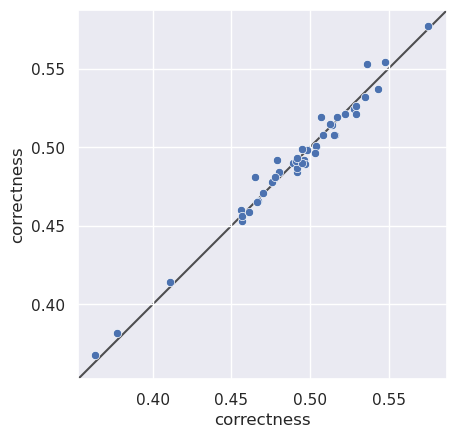

In [9]:
ax = sns.scatterplot(x=propagations[0]['correctness'], y=propagations[1]['correctness'])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [13]:
propagations[0].join(propagations[1], lsuffix='_a')

,correctness_a,correctness
synonym,,
absolutely,0.504,0.500
allow,0.575,0.577
assist,0.496,0.492
attempt,0.467,0.466
begin,0.504,0.501
decrease,0.456,0.460
difficulty,0.528,0.524
direction,0.492,0.484
equipment,0.491,0.490
